<div style="text-align: center; background-color: #0A6EBD; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Final Project - Introduction to Data Science
    <div style="text-align: center; background-color: #0A6EBD; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
    @ FIT-HCMUS, VNU-HCM 📌
</div>

<div style="text-align: center; background-color: #b1d1ff; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Stage 4.0 - Data modelling
</div>

## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

#!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

## Read data

In [2]:
movie_df = pd.read_csv('./../data/processed.csv')
movie_df

,Name,Released year,Genre,Director,Runtime (h),Score,Status,Language,Budget ($),Revenue ($)
0,Fast X,2023,"'Action', 'Crime', 'Thriller'",Dan Mazeau,2.37,72.0,Released,English,340000000.0,704709660.0
1,Trolls Band Together,2023,"'Animation', 'Family', 'Music', 'Fantasy', 'Co...",Thomas Dam,1.53,72.0,Released,English,95000000.0,173800000.0
2,Robot Apocalypse,2021,"'Science Fiction', 'Action'",Marcus Friedlander,1.45,21.0,Released,English,NaN,NaN
3,Five Nights at Freddy's,2023,"'Horror', 'Mystery'",Emma Tammi,1.83,78.0,Released,English,20000000.0,286700000.0
4,Oppenheimer,2023,"'Drama', 'History'",Christopher Nolan,3.02,81.0,Released,English,100000000.0,951000000.0
...,...,...,...,...,...,...,...,...,...,...
4995,Secret in Their Eyes,2015,"'Thriller', 'Mystery', 'Drama', 'Crime'",Billy Ray,1.85,64.0,Released,English,19500000.0,34854990.0
4996,The Vatican Tapes,2015,"'Thriller', 'Horror'",Mark Neveldine,1.52,53.0,Released,English,13000000.0,1784763.0
4997,Song to Song,2017,"'Romance', 'Drama', 'Music'",Terrence Malick,2.15,55.0,Released,English,10000000.0,1710528.0
4998,Divine Intervention,2023,'Comedy',Pedro Pablo Ibarra,1.67,82.0,Released,Spanish; Castilian,NaN,NaN


## Feature engineering

In [3]:
df = movie_df[['Genre', 'Runtime (h)', 'Score', 'Language', 'Budget ($)', 'Revenue ($)']].dropna()

one_hot_df = pd.DataFrame()
def splitGenre(s):
    return s.split(', ')
genre_stack = df['Genre'].apply(splitGenre).agg(pd.Series).stack().agg(pd.Series).stack()
genre_dummy = pd.get_dummies(genre_stack).groupby(level = 0).sum()
genre_dummy.columns = ['Genre_' + col.replace("'", "") for col in genre_dummy.columns]
df = pd.concat([genre_dummy, df], axis = 1)

label_encoder=LabelEncoder()
df['Language_encoded'] = label_encoder.fit_transform(df['Language'])

df = df.drop(['Genre', 'Language'], axis=1)

profit_percentage = (df['Revenue ($)'] - df['Budget ($)']) / df['Budget ($)']

df['Is_Profitable'] = df['Budget ($)'] < df['Revenue ($)']
df

,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Comedy,Genre_Crime,Genre_Drama,Genre_Family,Genre_Fantasy,Genre_History,Genre_Horror,...,Genre_TV Movie,Genre_Thriller,Genre_War,Genre_Western,Runtime (h),Score,Budget ($),Revenue ($),Language_encoded,Is_Profitable
0,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,2.37,72.0,340000000.0,704709660.0,5,True
1,0,0,1,1,0,0,1,1,0,0,...,0,0,0,0,1.53,72.0,95000000.0,173800000.0,5,True
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1.83,78.0,20000000.0,286700000.0,5,True
4,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,3.02,81.0,100000000.0,951000000.0,5,True
7,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1.80,65.0,40000000.0,8000000.0,5,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4990,1,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1.62,56.0,9000000.0,146863.0,5,False
4992,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1.85,67.0,23000000.0,19652638.0,5,False
4995,0,0,0,0,1,1,0,0,0,0,...,0,1,0,0,1.85,64.0,19500000.0,34854990.0,5,True
4996,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,1.52,53.0,13000000.0,1784763.0,5,False


## Data preparation

In [4]:
X = df.drop('Is_Profitable', axis=1)  # Features
y = df['Is_Profitable']  # Target

count = y.value_counts()
print(count)
print('Imbalance ratio: ' + str(count[True]/count[False]))

True     2521
False     448
Name: Is_Profitable, dtype: int64
Imbalance ratio: 5.627232142857143


- Mẫu có tỉ lệ mất cân bằng là 0.687, có nghĩa là số lượng mẫu trong lớp phân loại Successful bằng 0,687 lần số lượng mẫu trong lớp phân loại Unsuccessful
- Tỷ lệ này cho thấy một sự chênh lệch trong phân phối dữ liệu giữa hai lớp phân loại
- Vì vậy cần phải cân bằng dữ liệu

In [5]:
# Handle imbalance data
smote = SMOTE()
X, y = smote.fit_resample(X, y)
count = y.value_counts()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Training model

In [6]:
# Train the Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Train the SVM model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Train the KNN model
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

# Train the Multinomial Naive Bayes model
mnb_model = MultinomialNB()
mnb_model.fit(X_train, y_train)

MultinomialNB()

## Prediction

In [7]:
y_pred_rf = rf_model.predict(X_test)
y_pred_svm = svm_model.predict(X_test)
y_pred_knn = knn_model.predict(X_test)
y_pred_mnb = mnb_model.predict(X_test)

## Evaluation

In [8]:
pos_label = False

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, pos_label=pos_label)
recall_rf = recall_score(y_test, y_pred_rf, pos_label=pos_label)
f1_score_rf = f1_score(y_test, y_pred_rf, pos_label=pos_label)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, pos_label=pos_label)
recall_svm = recall_score(y_test, y_pred_svm, pos_label=pos_label)
f1_score_svm = f1_score(y_test, y_pred_svm, pos_label=pos_label)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, pos_label=pos_label)
recall_knn = recall_score(y_test, y_pred_knn, pos_label=pos_label)
f1_score_knn = f1_score(y_test, y_pred_knn, pos_label=pos_label)

accuracy_mnb = accuracy_score(y_test, y_pred_mnb)
precision_mnb = precision_score(y_test, y_pred_mnb, pos_label=pos_label)
recall_mnb = recall_score(y_test, y_pred_mnb, pos_label=pos_label)
f1_score_mnb = f1_score(y_test, y_pred_mnb, pos_label=pos_label)

print("== Random Forest ==")
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1-score:", f1_score_rf)

print("== SVM ==")
print("Accuracy:", accuracy_svm)
print("Precision:", precision_svm)
print("Recall:", recall_svm)
print("F1-score:", f1_score_svm)

print("== KNN ==")
print("Accuracy:", accuracy_knn)
print("Precision:", precision_knn)
print("Recall:", recall_knn)
print("F1-score:", f1_score_knn)

print("== Multinomial Naive Bayes ==")
print("Accuracy:", accuracy_mnb)
print("Precision:", precision_mnb)
print("Recall:", recall_mnb)
print("F1-score:", f1_score_mnb)

== Random Forest ==
Accuracy: 0.9742319127849356
Precision: 0.9696356275303644
Recall: 0.9775510204081632
F1-score: 0.9735772357723578
== SVM ==
Accuracy: 0.9613478691774033
Precision: 0.9262759924385633
Recall: 1.0
F1-score: 0.9617271835132483
== KNN ==
Accuracy: 0.9930624380574826
Precision: 0.9859154929577465
Recall: 1.0
F1-score: 0.9929078014184397
== Multinomial Naive Bayes ==
Accuracy: 0.958374628344896
Precision: 0.9210526315789473
Recall: 1.0
F1-score: 0.958904109589041


- Vậy RandomForest đạt hiệu suất cao, nhưng SVM, KNN và Multinomial Naive Bayes hiệu suất vẫn thấp nên sẽ tiến hành tinh chỉnh các siêu tham số trong mô hình SVM, KNN và Multinomial Naive Bayes

### SVM

In [9]:
# 1. Xác định các siêu tham số với các giá trị phổ biến của chúng để tinh chỉnh và phạm vi giá trị
param_grid_svm = {'C': [0.01, 0.1, 1, 10, 100], 
                  'gamma': ['scale', 'auto']}

# 2. Thực hiện tinh chỉnh siêu tham số sử dụng Grid Search và cross-validation
# Vì dữ liệu đã cân bằng nên đánh giá bằng accuracy
grid_search = GridSearchCV(svm_model, param_grid_svm, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# 3. Lấy ra các siêu tham số trong mô hình tốt nhất sau khi tinh chỉnh
best_svm_params = grid_search.best_params_

# 4. Sử dụng mô hình SVM tốt nhất
svm_model = SVC(**best_svm_params)

svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, pos_label=pos_label)
recall_svm = recall_score(y_test, y_pred_svm, pos_label=pos_label)
f1_score_svm = f1_score(y_test, y_pred_svm, pos_label=pos_label)

print("== New SVM ==")
print("Accuracy:", accuracy_svm)
print("Precision:", precision_svm)
print("Recall:", recall_svm)
print("F1-score:", f1_score_svm)

== New SVM ==
Accuracy: 0.9881070366699702
Precision: 0.9760956175298805
Recall: 1.0
F1-score: 0.9879032258064516


### KNN

In [10]:
param_grid_knn = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15], 
                  'weights': ['uniform', 'distance'], 
                  'metric': ['euclidean', 'manhattan']}

grid_search = GridSearchCV(knn_model, param_grid_knn, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_knn_params = grid_search.best_params_

knn_model = KNeighborsClassifier(**best_knn_params)
knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, pos_label=pos_label)
recall_knn = recall_score(y_test, y_pred_knn, pos_label=pos_label)
f1_score_knn = f1_score(y_test, y_pred_knn, pos_label=pos_label)

print("== New KNN ==")
print("Accuracy:", accuracy_knn)
print("Precision:", precision_knn)
print("Recall:", recall_knn)
print("F1-score:", f1_score_knn)

== New KNN ==
Accuracy: 0.998017839444995
Precision: 0.9959349593495935
Recall: 1.0
F1-score: 0.9979633401221996


## Multinomial Naive Bayes

In [11]:
param_grid_mnb = {'alpha': [0.1, 0.5, 1, 2],
                  'fit_prior': [True, False], 
                  'class_prior': [None, [0.3, 0.7], [0.5, 0.5]],}

grid_search = GridSearchCV(mnb_model, param_grid_mnb, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_mnb_params = grid_search.best_params_

mnb_model = MultinomialNB(**best_mnb_params)
mnb_model.fit(X_train, y_train)

y_pred_mnb = mnb_model.predict(X_test)

accuracy_mnb = accuracy_score(y_test, y_pred_mnb)
precision_mnb = precision_score(y_test, y_pred_mnb, pos_label=pos_label)
recall_mnb = recall_score(y_test, y_pred_mnb, pos_label=pos_label)
f1_score_mnb = f1_score(y_test, y_pred_mnb, pos_label=pos_label)

print("== New Multinomial Naive Bayes ==")
print("Accuracy:", accuracy_mnb)
print("Precision:", precision_mnb)
print("Recall:", recall_mnb)
print("F1-score:", f1_score_mnb)

== New Multinomial Naive Bayes ==
Accuracy: 0.958374628344896
Precision: 0.9210526315789473
Recall: 1.0
F1-score: 0.958904109589041


## Result & Models comparison

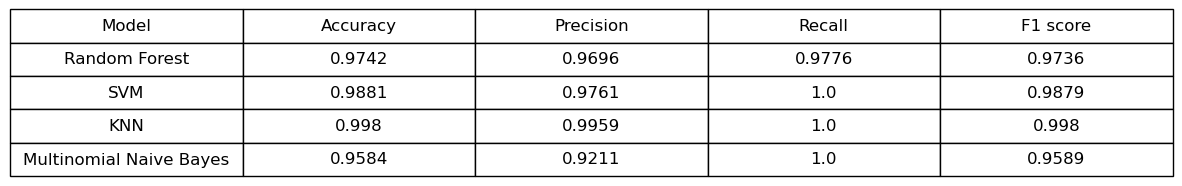

In [12]:
results = []
pos_labels = 'Successful'
models = ['Random Forest', 'SVM', 'KNN', 'Multinomial Naive Bayes']
for y_pred, model in zip([y_pred_rf, y_pred_svm, y_pred_knn, y_pred_mnb], models):
    accuracy = accuracy_score(y_test, y_pred).__round__(4)
    precision = precision_score(y_test, y_pred, pos_label=pos_label).__round__(4)
    recall = recall_score(y_test, y_pred, pos_label=pos_label).__round__(4)
    f1score = f1_score(y_test, y_pred, pos_label=pos_label).__round__(4)
    results.append([model, accuracy, precision, recall, f1score])

df_results = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 score'])

fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('off')
table = ax.table(cellText=df_results.values, colLabels=df_results.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.5, 2)

plt.show()

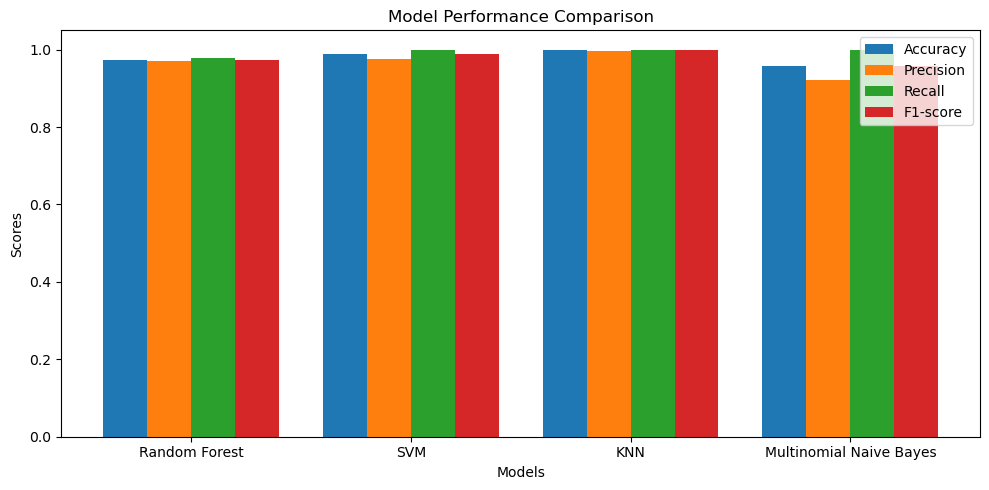

In [13]:
models = [item[0] for item in results]
accuracy = [item[1] for item in results]
precision = [item[2] for item in results]
recall = [item[3] for item in results]
f1_score = [item[4] for item in results]

bar_width = 0.2

index = np.arange(len(models))

plt.figure(figsize=(10, 5))

plt.bar(index, accuracy, bar_width, label='Accuracy')
plt.bar(index + (1 * bar_width), precision, bar_width, label='Precision')
plt.bar(index + (2 * bar_width), recall, bar_width, label='Recall')
plt.bar(index + (3 * bar_width), f1_score, bar_width, label='F1-score')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.xticks(index + (1.5 * bar_width), models)

plt.legend()
plt.tight_layout()
plt.show()

## Conclusion

Các mô hình có vẻ có hiệu quả đồng đều nhau